<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-동영상에-스티커-붙이기" data-toc-modified-id="1.-동영상에-스티커-붙이기-1">1. 동영상에 스티커 붙이기</a></span><ul class="toc-item"><li><span><a href="#(1)-동영상-처리-방법" data-toc-modified-id="(1)-동영상-처리-방법-1.1">(1) 동영상 처리 방법</a></span><ul class="toc-item"><li><span><a href="#동영상-확인하기" data-toc-modified-id="동영상-확인하기-1.1.1">동영상 확인하기</a></span></li><li><span><a href="#동영상-처리하기" data-toc-modified-id="동영상-처리하기-1.1.2">동영상 처리하기</a></span></li></ul></li><li><span><a href="#(2)-이미지-시퀀스에-스티커앱-적용하기" data-toc-modified-id="(2)-이미지-시퀀스에-스티커앱-적용하기-1.2">(2) 이미지 시퀀스에 스티커앱 적용하기</a></span></li><li><span><a href="#(3)-동영상-저장하기" data-toc-modified-id="(3)-동영상-저장하기-1.3">(3) 동영상 저장하기</a></span></li></ul></li><li><span><a href="#2.-더-빠른-스티커앱" data-toc-modified-id="2.-더-빠른-스티커앱-2">2. 더 빠른 스티커앱</a></span><ul class="toc-item"><li><span><a href="#(1)-실행시간-분석하기" data-toc-modified-id="(1)-실행시간-분석하기-2.1">(1) 실행시간 분석하기</a></span></li><li><span><a href="#(2)-얼굴-검출기-이해하기---속도,-안정성" data-toc-modified-id="(2)-얼굴-검출기-이해하기---속도,-안정성-2.2">(2) 얼굴 검출기 이해하기 - 속도, 안정성</a></span></li><li><span><a href="#(3)-칼만-필터" data-toc-modified-id="(3)-칼만-필터-2.3">(3) 칼만 필터</a></span><ul class="toc-item"><li><span><a href="#칼만-필터-적용하기" data-toc-modified-id="칼만-필터-적용하기-2.3.1">칼만 필터 적용하기</a></span></li><li><span><a href="#결과" data-toc-modified-id="결과-2.3.2">결과</a></span></li></ul></li></ul></li></ul></div>

# 1. 동영상에 스티커 붙이기
## (1) 동영상 처리 방법
### 동영상 확인하기

In [1]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ipython_display

In [2]:
import os
video_path = os.getenv('HOME')+'/aiffel/video_sticker_app/images/video2.mp4'
clip = VideoFileClip(video_path)
clip = clip.resize(width=640)
clip.ipython_display(fps=30, loop=True, autoplay=True, rd_kwargs=dict(logger=None))

### 동영상 처리하기

In [ ]:
# videocheck.py

import cv2

vc = cv2.VideoCapture('./images/video2.mp4')

vlen = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print (vlen) # video length

for i in range(vlen):
    ret, img = vc.read()
    if ret == False:
        break

    cv2.imshow('show', img)
    key = cv2.waitKey(1)
    if key == 27:
        break

## (2) 이미지 시퀀스에 스티커앱 적용하기

In [ ]:
# addsticker.py

import dlib
import cv2

def img2sticker_orig(img_orig, img_sticker, detector_hog, landmark_predictor):
    # preprocess
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    # detector
    dlib_rects = detector_hog(img_rgb, 0)
    if len(dlib_rects) < 1:
        return img_orig
    
    # landmark
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    # head coord
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] # nose
        y = landmark[30][1] - dlib_rect.width()//2
        w = dlib_rect.width()
        h = dlib_rect.width()
        break
    
    # sticker
    img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_NEAREST)
    
    refined_x = x - w // 2
    refined_y = y - h
    
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
        refined_y = 0

    img_bgr = img_orig.copy()
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.7, 0)

    return img_bgr


detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

vc = cv2.VideoCapture('./images/video2.mp4')
img_sticker = cv2.imread('./images/king.png')

vlen = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print (vlen) # 비디오 프레임의 총 개수


for i in range(vlen):
    ret, img = vc.read()
    if ret == False:
        break

    ## 추가된 부분
    start = cv2.getTickCount()
    img_result = img2sticker_orig(img, img_sticker.copy(), detector_hog, landmark_predictor)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    print ('[INFO] time: %.2fms'%time)
    
    cv2.imshow('show', img_result)
    key = cv2.waitKey(1)
    if key == 27:
        break

## (3) 동영상 저장하기

In [ ]:
# checkfourcc.py

import cv2

vc = cv2.VideoCapture('./images/video2.mp4')

fourcc = int(vc.get(cv2.CAP_PROP_FOURCC))
fourcc_str = "%c%c%c%c"%(fourcc & 255, (fourcc >> 8) & 255, (fourcc >> 16) & 255, (fourcc >> 24) & 255)
print ("CAP_PROP_FOURCC: ", fourcc_str)

In [ ]:
# savevideo.py

import dlib
import cv2

def img2sticker_orig(img_orig, img_sticker, detector_hog, landmark_predictor):
    # preprocess
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    # detector
    dlib_rects = detector_hog(img_rgb, 0)
    if len(dlib_rects) < 1:
        return img_orig
    
    # landmark
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    # head coord
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] # nose
        y = landmark[30][1] - dlib_rect.width()//2
        w = dlib_rect.width()
        h = dlib_rect.width()
        break
    
    # sticker
    img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_NEAREST)
    
    refined_x = x - w // 2
    refined_y = y - h
    
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
        refined_y = 0

    img_bgr = img_orig.copy()
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.7, 0)

    return img_bgr


detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

vc = cv2.VideoCapture('./images/video2.mp4')
img_sticker = cv2.imread('./images/king.png')

vlen = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print (vlen) # 비디오 프레임의 총 개수

# writer 초기화
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
vw = cv2.VideoWriter('./images/result.mp4', fourcc, 30, (1280, 720))


for i in range(vlen):
    ret, img = vc.read()
    if ret == False:
        break

    ## 추가된 부분
    start = cv2.getTickCount()
    img_result = img2sticker_orig(img, img_sticker.copy(), detector_hog, landmark_predictor)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    print ('[INFO] time: %.2fms'%time)

    # 매 프레임 마다 저장합니다.    
    vw.write(cv2.resize(img_result, (1280,720)))
    
    cv2.imshow('show', img_result)
    key = cv2.waitKey(1)
    if key == 27:
        break

vw.release()
cv2.destroyAllWindows()

# 2. 더 빠른 스티커앱
## (1) 실행시간 분석하기

In [ ]:
# addstiker_timecheck.py

import dlib
import cv2

def img2sticker_orig(img_orig, img_sticker, detector_hog, landmark_predictor):
    # preprocess
    start = cv2.getTickCount()
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    preprocess_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    # detector
    start = cv2.getTickCount()
    dlib_rects = detector_hog(img_rgb, 0)
    if len(dlib_rects) < 1:
        return img_orig
    detection_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    # landmark
    start = cv2.getTickCount()
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    landmark_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    # head coord
    start = cv2.getTickCount()
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] # nose
        y = landmark[30][1] - dlib_rect.width()//2
        w = dlib_rect.width()
        h = dlib_rect.width()
        # x,y,w,h = [ele*2 for ele in [x,y,w,h]]
        break
    coord_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    # sticker
    start = cv2.getTickCount()
    img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_NEAREST)

    refined_x = x - w // 2
    refined_y = y - h

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
        refined_y = 0

    img_bgr = img_orig.copy()
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.7, 0)
    sticker_time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

    print (f'p:{preprocess_time:.1f}ms, d:{detection_time:.1f}ms, l:{landmark_time:.1f}ms, c:{coord_time:.1f}ms, s:{sticker_time:.1f}ms')

    return img_bgr

detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

vc = cv2.VideoCapture('./images/video2.mp4')
img_sticker = cv2.imread('./images/king.png')

vlen = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print (vlen) # 비디오 프레임의 총 개수


for i in range(vlen):
    ret, img = vc.read()
    if ret == False:
        break

    ## 추가된 부분
    start = cv2.getTickCount()
    img_result = img2sticker_orig(img, img_sticker.copy(), detector_hog, landmark_predictor)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    print ('[INFO] time: %.2fms'%time)
    
    cv2.imshow('show', img_result)
    key = cv2.waitKey(1)
    if key == 27:
        break

## (2) 얼굴 검출기 이해하기 - 속도, 안정성

In [ ]:
# addstiker_modified.py

import dlib
import cv2

def img2sticker_orig(img_orig, img_sticker, detector_hog, landmark_predictor):
    # preprocess
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # detector
    # detector*와 landmark*에 입력되는 img_rgb 이미지를 VGA 크기로 1/4만큼 감소시킵니다.
    img_rgb_vga = cv2.resize(img_rgb, (640, 360))
    dlib_rects = detector_hog(img_rgb_vga, 0)
    if len(dlib_rects) < 1:
        return img_orig

    # landmark
    # 줄인만큼 스티커 위치를 다시 2배로 복원해야 합니다.
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb_vga, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    # head coord
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[30][0] # nose
        y = landmark[30][1] - dlib_rect.width()//2
        w = dlib_rect.width()
        h = dlib_rect.width()
        # 줄인 만큼 스티커 위치를 다시 2배로 복원해야 합니다.
        x,y,w,h = [ele*2 for ele in [x,y,w,h]]
        break

    # sticker
    img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_NEAREST)

    refined_x = x - w // 2
    refined_y = y - h

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
        refined_y = 0

    img_bgr = img_orig.copy()
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.7, 0)

    return img_bgr

detector_hog = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

vc = cv2.VideoCapture('./images/video2.mp4')
img_sticker = cv2.imread('./images/king.png')

vlen = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print (vlen) # 비디오 프레임의 총 개수


for i in range(vlen):
    ret, img = vc.read()
    if ret == False:
        break

    ## 추가된 부분
    start = cv2.getTickCount()
    img_result = img2sticker_orig(img, img_sticker.copy(), detector_hog, landmark_predictor)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    print ('[INFO] time: %.2fms'%time)
    
    cv2.imshow('show', img_result)
    key = cv2.waitKey(1)
    if key == 27:
        break

## (3) 칼만 필터
### 칼만 필터 적용하기
초기 위치 0에서 시작해서 20m/s 속도로 시간 단위 dt 로 idx 만큼 달렸다고 가정해봅시다.   
항상 똑같은 속도를 유지할 순 없기 때문에 w∼N(0,1) 만큼 조금씩 오차가 발생합니다.   
위치를 측정하는 기계 또한 매번 같은 결과를 내지 못하므로, v∼N(0,2) 만큼 오차가 발생했다고 가정하겠습니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
def get_pos_vel(idx, dt, init_pos=0, init_vel=20):
    w = np.random.normal(0, 1)                # w: system noise.
    v = np.random.normal(0, 2)                # v: measurement noise.

    vel_true = init_vel + w                   # nominal velocity = 80 [m/s].
    pos_true = init_pos + sum([vel_true*dt for i in range(idx)])
    z_pos_meas = pos_true + v                 # z_pos_meas: measured position (observable)
    
    return z_pos_meas, vel_true, pos_true#, v, w

1초 단위로 10번 측정해보면 아래와 같은 결과를 얻을 수 있습니다.

In [3]:
for i in range(0,10):
    print (get_pos_vel(i, 1))

(-3.4249602841564113, 20.38384941043617, 0)
(19.71577954337998, 21.75126150050709, 21.75126150050709)
(39.40996904883589, 20.32702150715143, 40.65404301430286)
(61.48699087651956, 20.5987857776482, 61.796357332944595)
(77.49326349535137, 19.212265655285282, 76.84906262114113)
(107.19401804684169, 21.64483964463117, 108.22419822315584)
(129.3731732316929, 21.382434700375967, 128.2946082022558)
(152.0115971713394, 21.61762231562503, 151.32335620937522)
(152.32227942824719, 18.94994585747732, 151.59956685981857)
(177.79773833401646, 19.896882255770144, 179.07194030193133)


칼만 필터를 구현하는 `kalman_filter()` 함수를 제작합니다.

In [4]:
def kalman_filter(z, x, P):
# Kalman Filter Algorithm
    # 예측 단계
    xp = A @ x
    Pp = A @ P @ A.T + Q

    # 추정 단계
    K = Pp @ H.T @ inv(H @ Pp @ H.T + R)
    x = xp + K @ (z - H @ xp)
    P = Pp - K @ H @ Pp
    return x, P

아래와 같이 칼만 필터 시스템 행렬 등의 초기 값을 지정합니다.

In [5]:
# time param
time_end = 5
dt = 0.05

위치 모델은 시간과 속도의 영향을 받습니다. 칼만 필터 입력으로 위치와 속도을 사용합니다(`x = [pos, vel]`).   
따라서 시스템 모델 A를 `pos + vel * dt` 형태의 연산이 가능하도록 설계합니다.   
아래와 같이 오차 행렬을 대략 초기화하였습니다.

In [6]:
# init matrix
A = np.array([[1, dt],
                       [0, 1]]) # pos * 1 + vel * dt = 예측 위치
H = np.array([[1, 0]])
Q = np.array([[1, 0],
                       [0, 1]])
R = np.array([[200]])

In [7]:
# Initialization for estimation.
x_0 = np.array([0, 20])  # position and velocity
P_0 = 1 * np.eye(2)

### 결과
결과를 저장할 공간을 만들어 두겠습니다. 시간 축으로 `time_end * dt` 개의 공간이 필요합니다.

In [8]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
pos_meas_save = np.zeros(n_samples)
vel_true_save = np.zeros(n_samples)
pos_esti_save = np.zeros(n_samples)
vel_esti_save = np.zeros(n_samples)

저장할 공간에 실제 위치와 칼만 필터 결과를 대입합니다.

In [9]:
pos_true = 0
x, P = None, None
for i in range(n_samples):
    z, vel_true, pos_true = get_pos_vel(i, dt)
    if i == 0:
        x, P = x_0, P_0
    else:
        x, P = kalman_filter(z, x, P)

    pos_meas_save[i] = z
    vel_true_save[i] = vel_true
    pos_esti_save[i] = x[0]
    vel_esti_save[i] = x[1]

Text(0, 0.5, 'Velocity [m/s]')

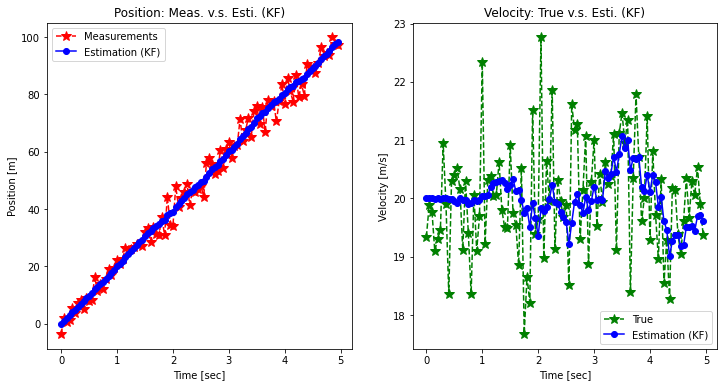

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time, pos_meas_save, 'r*--', label='Measurements', markersize=10)
plt.plot(time, pos_esti_save, 'bo-', label='Estimation (KF)')
plt.legend(loc='upper left')
plt.title('Position: Meas. v.s. Esti. (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Position [m]')

plt.subplot(1, 2, 2)
plt.plot(time, vel_true_save, 'g*--', label='True', markersize=10)
plt.plot(time, vel_esti_save, 'bo-', label='Estimation (KF)')
plt.legend(loc='lower right')
plt.title('Velocity: True v.s. Esti. (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Velocity [m/s]')

왼쪽 그래프는 시간과 위치의 그래프이고 오른쪽은 시간과 속도의 그래프입니다. 빨간색으로 표현된 실제 위치는 오차가 있기 때문에 노이즈가 있습니다. 반면 칼만 필터가 적용된 위치(파란색)는 안정적으로 나타나는 것을 볼 수 있습니다. 속도도 시스템 오차가 포함된 값에 비해 칼만 필터가 적용된 값이 실제(20m/s)에 가깝게 표현됩니다.